I use colab for training my model, so I transferred all needed functions here

In [1]:
!pip install datasets==2.11
!pip install datasets transformers[sentencepiece] sacrebleu
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate

In [2]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import spacy
from datasets import load_dataset, load_metric, list_metrics
import evaluate
import warnings
warnings.warn("ignore")


def create_dataframe(zip_file_path):
    # check if zip file exists
    if not os.path.exists(zip_file_path):
        print(f"zip file '{zip_file_path}' does not exist.")
        return None

    # extract zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files in the ZIP archive to a directory
        extraction_path = "./tmp_extraction"
        zip_ref.extractall(extraction_path)

    # find .tsv file
    tsv_file = None
    for root, dirs, files in os.walk(extraction_path):
        for file in files:
            if file.endswith(".tsv"):
                tsv_file = os.path.join(root, file)
                break

    if tsv_file is None:
        print("No .tsv file found in the extracted ZIP archive.")
        return None

    # create pandas DataFrame
    try:
        df = pd.read_csv(tsv_file, delimiter='\t')
        return df
    except Exception as e:
        print(f"Error while creating DataFrame: {str(e)}")
        return None
    finally:
        # remove the temporary extraction directory
        if os.path.exists(extraction_path):
            for root, dirs, files in os.walk(extraction_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    os.remove(file_path)
            os.rmdir(extraction_path)


def create_new_columns(dataset):
    # create new columns
    # dataset['toxic'] = [''] * dataset.shape[0]
    # dataset['nontoxic'] = [''] * dataset.shape[0]
    # dataset['toxic_tox'] = [''] * dataset.shape[0]
    # dataset['nontoxic_tox'] = [''] * dataset.shape[0]

    # create the 'toxic' and 'nontoxic' columns
    dataset['toxic'] = dataset.apply(lambda row: row['reference'] if row['ref_tox'] > row['trn_tox'] else row['translation'], axis=1)
    dataset['nontoxic'] = dataset.apply(lambda row: row['translation'] if row['ref_tox'] > row['trn_tox'] else row['reference'], axis=1)

    # create the 'toxic_tox' and 'nontoxic_tox' columns
    dataset['toxic_tox'] = dataset.apply(lambda row: row['ref_tox'] if row['ref_tox'] > row['trn_tox'] else row['trn_tox'], axis=1)
    dataset['nontoxic_tox'] = dataset.apply(lambda row: row['trn_tox'] if row['ref_tox'] > row['trn_tox'] else row['ref_tox'], axis=1)

    # drop unuseful columns
    dataset = dataset.drop(columns=['reference', 'translation', 'similarity', 'lenght_diff', 'ref_tox', 'trn_tox'])

    return dataset
    # return dataset['toxic'].tolist(), dataset['nontoxic'].tolist()


def remove_unuseful_data(dataset):
    # toxic sentences > 0.75 of toxic_tox: 0.9243254750535241
    dataset = dataset[dataset['toxic_tox'] > 0.75]

    # detoxed sentences < 0.25 of nontoxic_tox: 0.959344176040237
    dataset = dataset[dataset['nontoxic_tox'] < 0.25]

    return dataset


def get_sentences(dataset):
    # toxic and detoxed sentences
    return dataset['toxic'].tolist(), dataset['nontoxic'].tolist()


def split_train_test(toxic, nontoxic, path):
    toxic_train, toxic_test, nontoxic_train, nontoxic_test = train_test_split(
        toxic,
        nontoxic,
        test_size=0.25,
        random_state=42,
    )

    with open(os.path.join(path, 'toxic_train'), "w", encoding="UTF-8") as file:
        file.write("\n".join(toxic_train))
    with open(os.path.join(path, 'toxic_test'), "w", encoding="UTF-8") as file:
        file.write("\n".join(toxic_test))
    with open(os.path.join(path, 'nontoxic_train'), "w", encoding="UTF-8") as file:
        file.write("\n".join(nontoxic_train))
    with open(os.path.join(path, 'nontoxic_test'), "w", encoding="UTF-8") as file:
        file.write("\n".join(nontoxic_test))

def save_csv(dataset):
    dataset.to_csv("converted.csv")

def get_dict():
    return load_dataset("csv", data_files="converted.csv")

<ipython-input-2-8c4f2d1d18af>:9: UserWarning: ignore
  warnings.warn("ignore")


In [3]:
print(list_metrics())

['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'DarrenChensformer/eval_keyphrase', 'DarrenChensformer/relation_extraction', 'Drunper/metrica_tesi', 'Felipehonorato/eer', 'He-Xingwei/sari_metric', 'Ikala-allen/relation_extraction', 'JP-SystemsX/nDCG', 'Josh98/nl2bash_m', 'Muennighoff/code_eval_octopack', 'NCSOFT/harim_plus', 'Natooz

<ipython-input-3-aa800e427431>:5: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  print(list_metrics())


In [4]:
bleu = load_metric("sacrebleu")
ter = load_metric("ter")
rouge = evaluate.load("rouge")

<ipython-input-4-20b8eac90747>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric("sacrebleu")


In [5]:
dataset = create_dataframe("drive/MyDrive/filtered_paranmt.zip")

In [6]:
dataset = create_new_columns(dataset)
dataset = remove_unuseful_data(dataset)

In [7]:
save_csv(dataset)

In [8]:
dataset_dict = load_dataset("csv", data_files="converted.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b8c38739c84397d5/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'toxic', 'nontoxic', 'toxic_tox', 'nontoxic_tox'],
        num_rows: 510564
    })
})

In [10]:
from transformers import AutoTokenizer

def tokenize(dataset, model_checkpoint='s-nlp/bart-base-detox'):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    max_input_length = 80
    max_target_length = 80
    prefix = ""

    inputs = [prefix + ex for ex in dataset["toxic"]]
    targets = [ex for ex in dataset["nontoxic"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
tokenize(dataset_dict['train'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [12]:
tokenized_datasets = dataset_dict.map(tokenize, batched=True)

Map:   0%|          | 0/510564 [00:00<?, ? examples/s]

In [13]:
model_checkpoint = 's-nlp/bart-base-detox' # 's-nlp/t5-paranmt-detox'

In [14]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [55]:
batch_size = 64
model_name = model_checkpoint.split("/")[-1]
toxic_str = "toxic"
nontoxic_str = "nontoxic"
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{toxic_str}-to-{nontoxic_str}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    save_steps = 500,
    eval_steps=500,
    logging_steps=100,
)

In [56]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [57]:
import gc
import torch

def cleanup():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

cleanup()

In [58]:
import numpy as np

metrics = []

def compute_metrics(eval_preds):
    global metrics
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    ter_score = ter.compute(predictions=decoded_preds, references=decoded_labels)
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": bleu_score["score"]}
    result["ter"] = ter_score["score"]
    result["rouge1"] = rouge_score["rouge1"]
    result["rouge2"] = rouge_score["rouge2"]

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    metrics.append(result)
    cleanup()
    return result

In [59]:
splitted_dataset = tokenized_datasets["train"].select(range(70000)).train_test_split(test_size=0.1)

In [60]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'toxic', 'nontoxic', 'toxic_tox', 'nontoxic_tox', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 63000
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'toxic', 'nontoxic', 'toxic_tox', 'nontoxic_tox', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7000
    })
})

In [61]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=splitted_dataset["train"],
    eval_dataset=splitted_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [62]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu,Ter,Rouge1,Rouge2,Gen Len
1,1.636400,1.697432,24.537958,62.839245,0.582734,0.359215,20.000000
2,1.631700,1.685538,25.062905,62.689198,0.585390,0.362630,20.000000
3,1.565000,1.675177,24.896358,62.696482,0.584434,0.361909,20.000000
4,1.514000,1.676973,24.987388,62.459028,0.584841,0.364489,20.000000
5,1.471300,1.669789,25.015345,62.574113,0.584948,0.364349,20.000000
6,1.436800,1.679861,24.842421,62.587224,0.584105,0.362713,20.000000
7,1.377300,1.680224,25.023409,62.550805,0.584767,0.364268,20.000000
8,1.350500,1.683352,24.891115,62.559545,0.584269,0.363596,20.000000
9,1.348500,1.686537,24.962534,62.593051,0.583856,0.364083,20.000000
10,1.327300,1.689901,24.962550,62.626557,0.583466,0.362754,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=9850, training_loss=1.4586198921009974, metrics={'train_runtime': 5503.7866, 'train_samples_per_second': 114.467, 'train_steps_per_second': 1.79, 'total_flos': 1.774421695807488e+16, 'train_loss': 1.4586198921009974, 'epoch': 10.0})

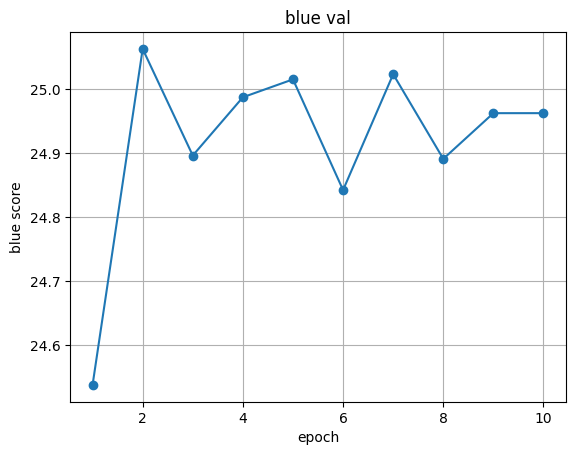

In [63]:
import matplotlib.pyplot as plt

bleu_scores = []
for i in range(len(metrics)):
    bleu_scores.append(metrics[i]["bleu"])

# epochs
indices = range(1, len(bleu_scores) + 1)

plt.plot(indices, bleu_scores, marker='o', linestyle='-')
plt.title('blue val')
plt.xlabel('epoch')
plt.ylabel('blue score')
plt.grid(True)

plt.show()

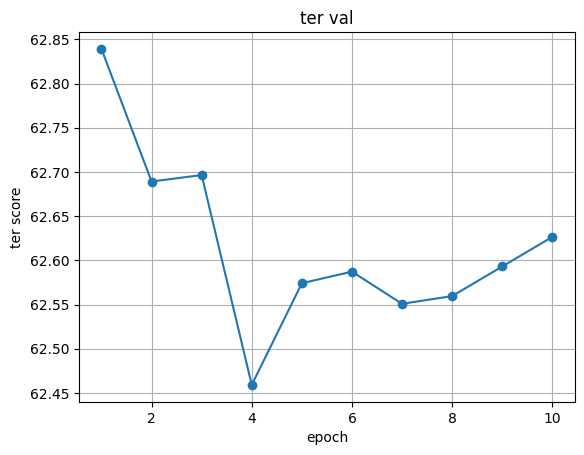

In [64]:
import matplotlib.pyplot as plt

ter_scores = []
for i in range(len(metrics)):
    ter_scores.append(metrics[i]["ter"])

# epochs
indices = range(1, len(ter_scores) + 1)

plt.plot(indices, ter_scores, marker='o', linestyle='-')
plt.title('ter val')
plt.xlabel('epoch')
plt.ylabel('ter score')
plt.grid(True)

plt.show()

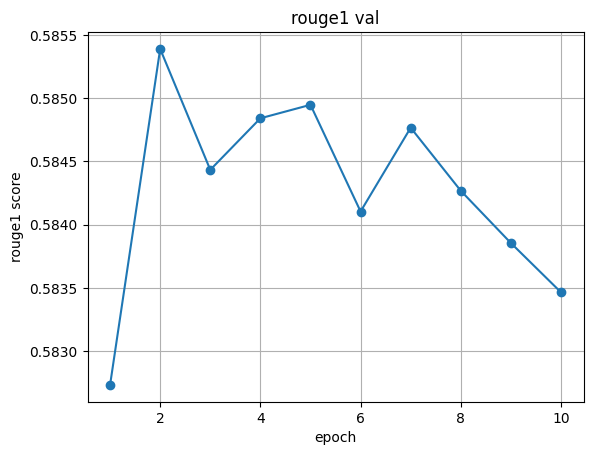

In [65]:
import matplotlib.pyplot as plt

rouge1_scores = []
for i in range(len(metrics)):
    rouge1_scores.append(metrics[i]["rouge1"])

# epochs
indices = range(1, len(rouge1_scores) + 1)

plt.plot(indices, rouge1_scores, marker='o', linestyle='-')
plt.title('rouge1 val')
plt.xlabel('epoch')
plt.ylabel('rouge1 score')
plt.grid(True)

plt.show()

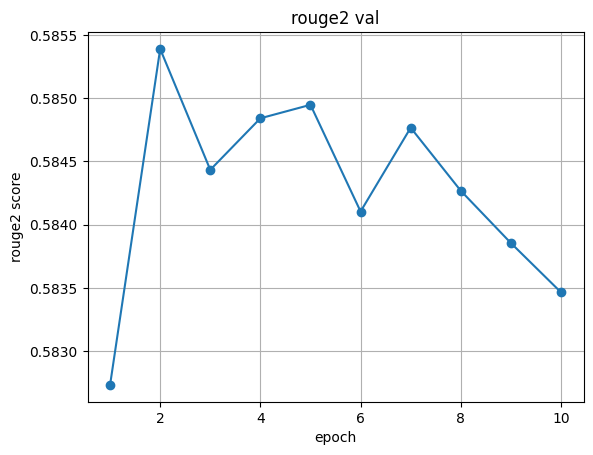

In [66]:
import matplotlib.pyplot as plt

rouge2_scores = []
for i in range(len(metrics)):
    rouge2_scores.append(metrics[i]["rouge2"])

# epochs
indices = range(1, len(rouge2_scores) + 1)

plt.plot(indices, rouge1_scores, marker='o', linestyle='-')
plt.title('rouge2 val')
plt.xlabel('epoch')
plt.ylabel('rouge2 score')
plt.grid(True)

plt.show()

In [ ]:
metrics[0]

In [67]:
trainer.save_model('drive/MyDrive/best')

In [68]:
predictions, labels, metrics = trainer.predict(splitted_dataset["test"], metric_key_prefix="predict")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [69]:
my_predictions = tokenizer.batch_decode(
                    predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
                )

In [70]:
splitted_dataset["test"]["toxic"][40:55]

["I swear I will! I'll shoot you!",
 "and I'm about to make you crazy with all your worries.",
 "you'd be able to take a cripple like Quasimodo for a husband, or rather a rich man.",
 'will you destroy her, please?',
 "I can't stay here another fucking second.",
 '"you\'d be a loser, sweetheart."',
 "Hey dog, don't cry for thatmotherfucker because, WOW!",
 'I fucked Ana.',
 "he's full of shit, right?",
 "by the end of your life, you'll be hopping depending on which side of your damn Luck is going to pull.",
 'Outdoor fucking has its drawbacks.',
 "I'm just an old poor man, my eyes palate, my ears pathetic, my nose bleedin '.",
 "if you say you can't, you'll die.",
 "You hungry? I saved what's left of Noisy's voice recognition board. Other than that, he's trash.",
 'It helps lovely tourists, such as yourself... ...loosen up without impairing your ability to stay awake... ...and have guilt-free, vigorous sex with me.']

In [71]:
my_predictions[40:55]

["I swear I'll do it!",
 "And I'm about to make you crazy with all your worries.",
 "You'd be able to take a cripple like Quasimodo for a husband",
 'Will you destroy it, please?',
 "I can't stay here for another minute.",
 '"You\'d be a loser, sweetheart."',
 "hey, dog, don't cry, 'cause, WOW!",
 'I slept with Ana.',
 "He's full of it, right?",
 "By the end of your life, you'll be hopping around depending on which side of",
 'outdoor boredom has its advantages.',
 "I'm just an old man with a palate, an earsight, and a nose",
 "If you say you can't, you're dead.",
 "I saved what's left of Noisy's voice recognition board, but other than that",
 'it helps lovely tourists such as yourself to relax without affecting the ability to stay awake and']

In [ ]:
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer

class ToxicityClassifier:
    def __init__(self, model_name='s-nlp/roberta_toxicity_classifier_v1'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = RobertaForSequenceClassification.from_pretrained(model_name).to(self.device)
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)

    def text_toxicity(self, texts):
        """
        baseline model
        https://huggingface.co/s-nlp/roberta_toxicity_classifier_v1
        """
        with torch.no_grad():
            input_ids = self.tokenizer(texts, return_tensors='pt', padding=True).to(self.device)
            logits = self.model(**input_ids).logits
            probabilities = torch.softmax(logits, -1)
            toxicity_scores = probabilities[:, 1].cpu().numpy()
        return toxicity_scores

    def delete_toxic(self, toxic_sentences, threshold=0.5):
        """
        remove toxic words from a list of sentences
        """
        nontoxic_text = []
        for toxic_sentence in toxic_sentences:
            words = toxic_sentence.split()
            toxic_scores = self.text_toxicity(words)
            nontoxic_words = []
            for word, score in zip(words, toxic_scores):
                if score < threshold:
                    nontoxic_words.append(word)
            nontoxic_text.append(" ".join(nontoxic_words))
        return nontoxic_text


In [ ]:
toxic, nontoxic = get_sentences(dataset)

In [ ]:
clf = ToxicityClassifier()

deleted_toxic = clf.delete_toxic(['it was perfectly planned, but stupidly done.'])

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
deleted_toxic

['it was perfectly planned, but done.']

In [ ]:
toxic[:50]

Come on, Cal, leave that alone. \\
Come on, Cal, leave that shit alone.

In [ ]:
import gc

def cleanup():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

cleanup()